In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os.path import basename
from os.path import join
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# Required files
For each value of $p$ (downsampling):
- individual performance tables for each model replicate in the ensemble (x10)
- the ensemble average performance (x1)
- individual performance tables for each distilled model replicate (x10)

# Steps
## For performance of individual models (original and distilled):
1. Load each file for each value of $p$ (downsampling)
2. Concatenate files across replicates
3. Add a `label` column (original or distilled)
4. Melt dataframe 
If making plotly plots:
5. Calculate mean and std. for each metric (Pearson, Spearman, MSE) across replicates for each value of $p$ and class of enhancer (Dev, Hk)
## For ensemble average performance 
1. Load each file for each value of $p$ (downsampling)
2. Concatenate files across replicates
3. Melt dataframe 
4. Add a `label` column and populate with `ensemble average`

# Helper functions

In [2]:
def parse_replicate_performance(root_dir, p=1, distilled=False, std=False, evoaug=False):
    '''for a single value of p, parse performance files for all replicates and return a dataframe'''
    if p != 1:
        root_dir = join(root_dir, f'downsample_{p}')
    if distilled:
        if std:
            root_dir = join(root_dir, "distilled_with_std")
            # if p == 1:
            #     root_dir = join(root_dir, "distilled_with_std")
            # else:
            #     root_dir = join(root_dir, "distilled_with_std_REDO")
        else:
            root_dir = join(root_dir, "ensemble_distilled")
        print(root_dir)
    performance_files = glob.glob(join(root_dir, ["*_performance.csv", "*_performance_finetune.csv"][int(evoaug)]))

    results_list = []
    for f in performance_files:
        df = pd.read_csv(f)
        model_ix = int(basename(f).split('_')[0])
        df['model_ix'] = model_ix
        if 'metric' not in df.columns:
            df['metric'] = ['MSE', 'Pearson', 'Spearman']
        results_list.append(df)

    # combine as one df
    all_results = pd.concat(results_list)
    all_results['model_ix'] = all_results['model_ix'].astype('int32')
    all_results.sort_values(by = 'model_ix', inplace=True)
    all_results.reset_index(drop=True, inplace=True)
    all_results['downsample'] = p
    all_results['label'] = ['original', 'distilled'][int(distilled)]
    
    return all_results


def summarise_across_downsamples(root_dir, distilled=False, std=False, evoaug=False, downsample_arr=[0.1, 0.25, 0.5, 0.75, 1], ensemble_avg=False):
    '''
    parses performance files across all replicates for all downsampling proportions 
    resulting file is compatible for plotting 
    '''
    if ensemble_avg:
        print('summarising across ensemble average performance')
        assert(distilled is not True) #ensemble avg only applies to the ensemble of models
        dfs_list = []
        for p in downsample_arr:
            df = None
            if p!=1:
                df = pd.read_csv(join(root_dir, f'downsample_{p}', 'ensemble_performance_avg.csv'))
            else:
                df = pd.read_csv(join(root_dir, 'ensemble_performance_avg.csv'))
            df['downsample'] = p
            dfs_list.append(df)
        full_performance_summary = pd.concat(dfs_list)
        melted_df = pd.melt(full_performance_summary, id_vars=['metric', 'downsample'], var_name='enhancer')
        melted_df['label'] = 'average'
        return melted_df
    else:
        dfs_list = [parse_replicate_performance(root_dir, p=p, distilled=distilled, std=std, evoaug=evoaug) for p in downsample_arr]
        full_performance_summary = pd.concat(dfs_list)
        # melt 
        melted_df = pd.melt(full_performance_summary, id_vars=['metric', 'model_ix', 'downsample', 'label'], var_name='enhancer')
        # ### add metrics for plotly
        # # add mean of metrics
        # melted_df['mean'] = melted_df.groupby(['metric','downsample','enhancer'])['value'].transform('mean')
        # # add standard deviation of metrics
        # melted_df['sd'] = melted_df.groupby(['metric','downsample','enhancer'])['value'].transform('std')
        # sort by downsample
        melted_df.sort_values('downsample', inplace=True)
        return melted_df


def plot_with_seaborn(plotdf, plot_title, metric='Pearson', transparent=False, outfh=None):
    g = sns.FacetGrid(plotdf[(plotdf['metric']==metric)], col="enhancer", hue="label", height=3, aspect=0.5)
    g.map_dataframe(sns.lineplot, x="downsample", y="value", marker='o')
    g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
    # g.add_legend(bbox_to_anchor=(0.99, 0.88), loc='upper left')
    g.legend.set_title('Model')
    if metric != 'MSE':
        g.set_ylabels(f'{metric} r')
    else:
        g.set_ylabels(metric)
    g.figure.suptitle(plot_title)
    g.figure.tight_layout()
    if outfh is not None:
        g.savefig(outfh, dpi=300, transparent=transparent)
    else:
        g.figure.show()
        

In [3]:
# root_dir = '../results/DeepSTARR_lr-decay' # parent dir for all output files
root_dir = "../results/DeepSTARR_ensemble_NEW"
original_df = summarise_across_downsamples(root_dir, distilled=False, evoaug=False)
distilled_df = summarise_across_downsamples(root_dir, distilled=True, std=True, evoaug=False)
ensemble_avg_df = summarise_across_downsamples(root_dir, evoaug=False, ensemble_avg=True)
deepstarr_plotdf = pd.concat([original_df, distilled_df, ensemble_avg_df])


../results/DeepSTARR_ensemble_NEW/downsample_0.1/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.25/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.5/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.75/distilled_with_std
../results/DeepSTARR_ensemble_NEW/distilled_with_std
summarising across ensemble average performance


In [4]:
deepstarr_plotdf.rename(columns={"enhancer": "output"}, inplace=True)

In [5]:
deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['label']=='distilled') & (deepstarr_plotdf['downsample']==0.1) & (deepstarr_plotdf['model_ix']==1.0)]

,metric,model_ix,downsample,label,output,value
451,Pearson,1.0,0.1,distilled,Hk-std,0.622106
151,Pearson,1.0,0.1,distilled,Hk,0.667410
301,Pearson,1.0,0.1,distilled,Dev-std,0.632158
1,Pearson,1.0,0.1,distilled,Dev,0.547869


In [18]:
# save to file 
deepstarr_plotdf.to_csv('../results/DeepSTARR_ensemble_NEW/distillation_performance_plotdf.csv', index=False)

In [6]:
# load file
deepstarr_plotdf = pd.read_csv('../results/DeepSTARR_ensemble_NEW/distillation_performance_plotdf.csv')
deepstarr_plotdf.head()

,metric,model_ix,downsample,label,output,value
0,MSE,1.0,0.1,original,Dev,1.892400
1,Pearson,1.0,0.1,original,Hk,0.622676
2,Spearman,1.0,0.1,original,Hk,0.456262
3,MSE,2.0,0.1,original,Hk,1.814907
4,Pearson,2.0,0.1,original,Hk,0.612350


Get data into unmelted dataframes

In [7]:
downsample_arr = [0.1, 0.25, 0.5, 0.75, 1]
original_unmelted = pd.concat([parse_replicate_performance(root_dir, p=p, distilled=False, std=False, evoaug=False) for p in downsample_arr])
distilled_unmelted = pd.concat([parse_replicate_performance(root_dir, p=p, distilled=True, std=True, evoaug=False) for p in downsample_arr])

ensemble_avg_dfs_list = []
for p in downsample_arr:
    df = None
    if p!=1:
        df = pd.read_csv(join(root_dir, f'downsample_{p}', 'ensemble_performance_avg.csv'))
    else:
        df = pd.read_csv(join(root_dir, 'ensemble_performance_avg.csv'))
    df['downsample'] = p
    ensemble_avg_dfs_list.append(df)
ensemble_avg_unmelted = pd.concat(ensemble_avg_dfs_list)


../results/DeepSTARR_ensemble_NEW/downsample_0.1/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.25/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.5/distilled_with_std
../results/DeepSTARR_ensemble_NEW/downsample_0.75/distilled_with_std
../results/DeepSTARR_ensemble_NEW/distilled_with_std


Generate dictionary of performance metrics

In [8]:
original_dict = {}

for enhancer in ['Dev','Hk']:
    original_dict[enhancer] = {}
    for metric in ['MSE','Pearson','Spearman']:
        original_dict[enhancer][metric] = {}
        for p in [0.1, 0.25, 0.5, 0.75, 1]:
            original_dict[enhancer][metric][p] = original_unmelted[(original_unmelted['metric']==metric) & (original_unmelted['downsample']==p)][enhancer].tolist()

In [9]:
distilled_dict = {}

for output in ['Dev','Hk', 'Dev-std','Hk-std']:
    distilled_dict[output] = {}
    for metric in ['MSE','Pearson','Spearman']:
        distilled_dict[output][metric] = {}
        for p in [0.1, 0.25, 0.5, 0.75, 1]:
            distilled_dict[output][metric][p] = distilled_unmelted[(distilled_unmelted['metric']==metric) & (distilled_unmelted['downsample']==p)][output].tolist()

In [10]:
ensemble_avg_dict = {}

for output in ['Dev','Hk']:
    ensemble_avg_dict[output] = {}
    for metric in ['MSE','Pearson','Spearman']:
        ensemble_avg_dict[output][metric] = {}
        for p in [0.1, 0.25, 0.5, 0.75, 1]:
            ensemble_avg_dict[output][metric][p] = ensemble_avg_unmelted[(ensemble_avg_unmelted['metric']==metric) & (ensemble_avg_unmelted['downsample']==p)][output].tolist()

In [11]:
# combine
results_dict = {'original': original_dict,
                'distilled': distilled_dict,
                'ensemble_avg': ensemble_avg_dict}

In [12]:
# save pickle
import pickle 
with open('../results/DeepSTARR_ensemble_NEW/DeepSTARR_performance.pickle', 'wb') as fh:
    pickle.dump(results_dict, fh, protocol=pickle.HIGHEST_PROTOCOL)


# Performance curves for mean head

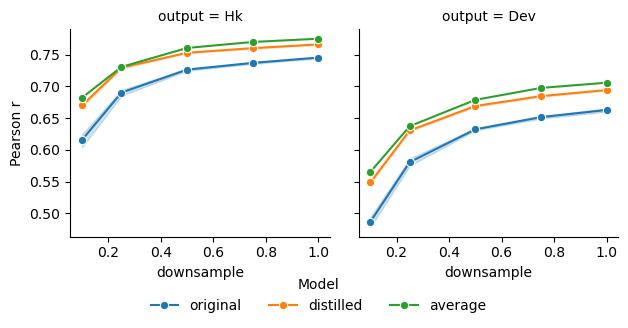

In [36]:
g = sns.FacetGrid(deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & deepstarr_plotdf['output'].isin(['Dev','Hk'])], col="output", hue="label", col_wrap=2, height=3, aspect=0.5)
g.map_dataframe(sns.lineplot, x="downsample", y="value", marker='o')
g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
g.legend.set_title('Model')
g.set_ylabels('Pearson r')
g.figure.tight_layout()
# g.figure.show()
g.savefig("../results/DeepSTARR_ensemble_NEW/performance_curves.png", dpi=300, transparent=False)

Plot Dev only

In [11]:
# Define mapping function
def map_values(x):
    if x=='original':
        return 'individual'
    else:
        return x
deepstarr_plotdf['label']=deepstarr_plotdf['label'].apply(map_values)

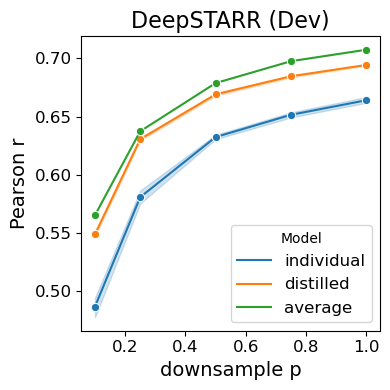

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
sns.lineplot(data=deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['output']=='Dev')], x="downsample", y="value", hue='label',marker='o', ax=ax)
ax.legend(title='Model', fontsize=12)
ax.set_ylabel('Pearson r', fontsize=14)
ax.set_xlabel('downsample p', fontsize=14)
ax.set_title('DeepSTARR (Dev)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
# fig.show()
fig.savefig("DeepSTARR_Dev_ensemble_distillation_performance_curves.pdf")

# Performance for epistemic uncertainty head

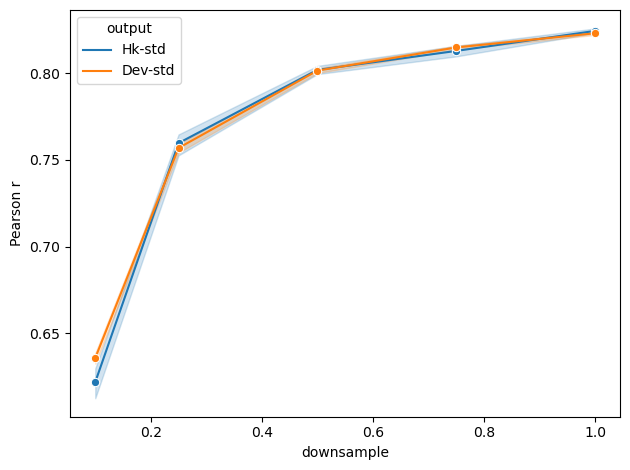

In [33]:
### plotting for MLCB fig. 1c
std_pearson = deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['output'].isin(['Dev-std','Hk-std']))]

g = sns.lineplot(std_pearson, x="downsample", y="value", hue="output", marker='o')
g.set_ylabel('Pearson r')
g.figure.tight_layout()
g.figure.show()
# g.figure.savefig("../results/DeepSTARR_lr-decay/MLCB_1c.png", dpi=300, transparent=False)

# Plot performance curves for mean head with performance curves for epistemic head

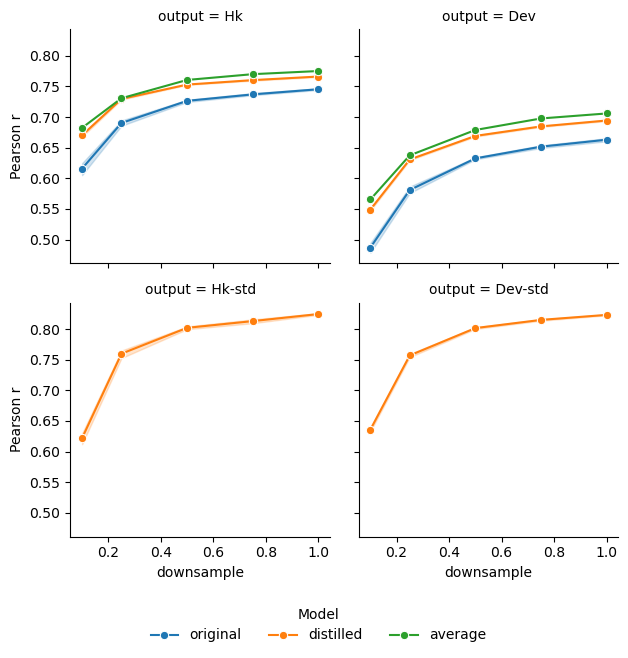

In [6]:
# fig = plt.figure(constrained_layout=True)
# gs = fig.add_gridspec(2,2)
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, :])

g = sns.FacetGrid(deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson')], col="output", hue="label", col_wrap=2, height=3, aspect=0.5)
g.map_dataframe(sns.lineplot, x="downsample", y="value", marker='o')
g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
g.legend.set_title('Model')
g.set_ylabels('Pearson r')
g.figure.tight_layout()
# g.figure.show()
g.figure.savefig("../figures/DeepSTARR_performance_curves.png", dpi=300, bbox_inches='tight')

Plot Dev only for MLCB

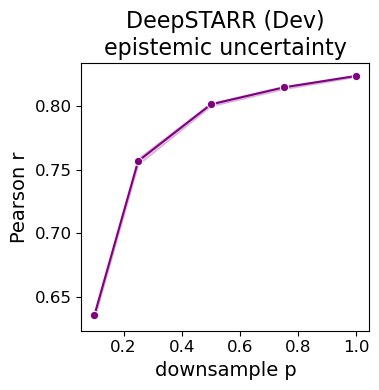

In [32]:
dev_epistemic = deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['output']=='Dev-std')]

fig, ax = plt.subplots(figsize=(4,4))
palette = {'Dev-std': 'purple'}
sns.lineplot(dev_epistemic, x="downsample", y="value", hue="output", marker='o', legend=False, ax=ax, palette=palette)
ax.set_ylabel('Pearson r')
ax.set_ylabel('Pearson r', fontsize=14)
ax.set_xlabel('downsample p', fontsize=14)
ax.set_title('DeepSTARR (Dev)\nepistemic uncertainty', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig("DeepSTARR_Dev_epistemic_performance_curve.pdf")

Plot Dev performance curves for mean and epistemic together

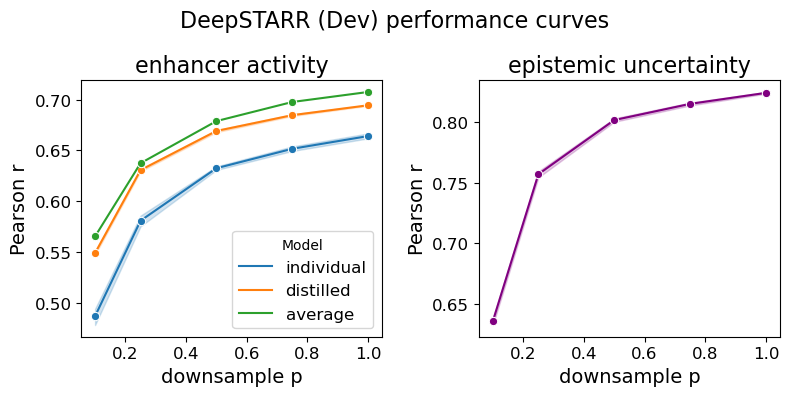

In [30]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
sns.lineplot(data=deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['output']=='Dev')], x="downsample", y="value", hue='label',marker='o', ax=axs[0])
axs[0].legend(title='Model', fontsize=12)
axs[0].set_ylabel('Pearson r', fontsize=14)
axs[0].set_xlabel('downsample p', fontsize=14)
axs[0].set_title('enhancer activity', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12)

dev_epistemic = deepstarr_plotdf[(deepstarr_plotdf['metric']=='Pearson') & (deepstarr_plotdf['output']=='Dev-std')]

palette = {'Dev-std': 'purple'}
sns.lineplot(dev_epistemic, x="downsample", y="value", hue="output", marker='o', legend=False, ax=axs[1], palette=palette)
axs[1].set_ylabel('Pearson r')
axs[1].set_ylabel('Pearson r', fontsize=14)
axs[1].set_xlabel('downsample p', fontsize=14)
axs[1].set_title('epistemic uncertainty', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12)

fig.suptitle('DeepSTARR (Dev) performance curves', fontsize=16)
fig.tight_layout()
# fig.show()
fig.savefig("DeepSTARR_Dev_ensemble_distillation_performance_curves_mean_and_epistemic.pdf")

# MSE for epistemic uncertainty head

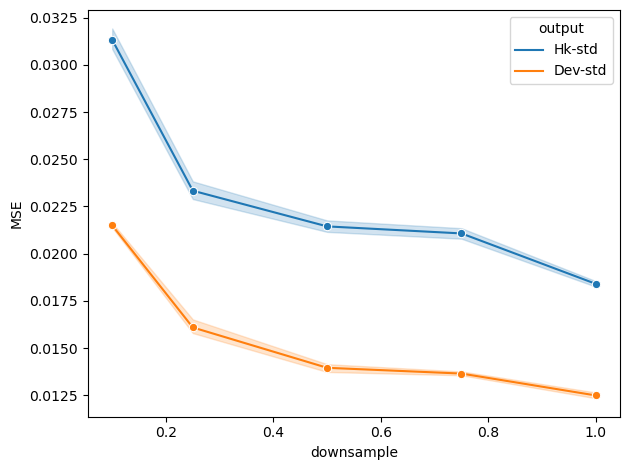

In [35]:
### plotting for MLCB fig. 1c
std_loss_plotdf = deepstarr_plotdf[(deepstarr_plotdf['metric']=='MSE') & (deepstarr_plotdf['output'].isin(['Dev-std','Hk-std']))]

g = sns.lineplot(std_loss_plotdf, x="downsample", y="value", hue="output", marker='o')
g.set_ylabel('MSE')
g.figure.tight_layout()
g.figure.show()
# g.figure.savefig("../results/DeepSTARR_lr-decay/distilled_with_std_MSE.png", dpi=300, transparent=False)